# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de Tenerife

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def visualizar_STL(df):
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()

    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

    plt.xticks(rotation=90)
    plt.show()
    

def visualizar_adf(df):
    ''' Visualiza el p-valor del estudio de Dickey-Fuller para determinar la estacionalidad de los datos
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''

    adf = adfuller(df)
    print("ADF p-value:" + str(adf[1]))
    

def visualizar_acf(df, n_lags):
    plt.figure(figsize=(16, 10))
    plot_acf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.show()
    
def visualizar_pacf(df, n_lags):
    plt.figure(figsize=(16, 6))
    plot_pacf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
    
    Args:
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
        tit(string): título del gráfico
    '''
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')

    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.xticks(rotation=60)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, tit, color, dif):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
        y muestra el historico de casos en función del número de días que indiquemos que muestre
    
    Args:
        train (DataFrame): Conjunto de datos de entrenamiento
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable (string): Variable objetivo
        dias_historico (integer): días hacia atrás a mostrar del historico
        tit (string): título del gráfico
        color (string): color de la isla para visualizar
    '''
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color)
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color)
        plt.plot(test.index, test, label='Test', color='green')
    
    plt.plot(test.index, pred, label='Predicción', color='orange')
    plt.bar(test.index, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(test.index), step=5),   train_s.index.union(test.index)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_bic_aic(modelo):
    ''' Visualiza los datos de BIC (Criterio de Información Bayesiano) y  AIC (Criterio de Información de Akaike)
    
    Args:
        modelo (ARIMA): modelo ARIMA entrenado
    '''
    
    bic = modelo.bic
    aic = modelo.aic

    print("BIC del modelo ARIMA:", bic)
    print("AIC del modelo ARIMA:", aic)
    
def visualizar_resultados_texto(y_test, y_pred, variable):
    ''' Método que visualiza por pantalla en formato de texto el número de csaos reales y los predichos por el algoritmo
    
    Args:
        y_test (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    fechas = y_test.index
    for i in range(len(y_test)):
        if variable != '':
            valor_test = y_test[variable][i]
        else:
            valor_test = y_test[i] 
        print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))
        
def obtener_df_diferencias(test, pred, variable):
    df_result = test.copy()
    if variable != '':
        df_result = df_result[variable]
        df_result = df_result.to_frame()
    else:
        df_result = df_result.to_frame()
    df_result['pred'] = 0
    df_result['dif'] = 0

    for i in range(len(df_result)):
        df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
        df_result.iloc[i, df_result.columns.get_loc('dif')] = df_result['numero_casos'][i] - pred[i]
        
    return df_result

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_Tenerife = datos_islas[datos_islas['isla'] == 'TENERIFE'].copy()


datos_Tenerife = datos_Tenerife.sort_values(by='fecha')   # Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_Tenerife.set_index('fecha', inplace=True)           # Añadimos como índice de los datos la fecha

In [4]:
# Variables globales a utilizar en todo el proceso


objetivo = 'numero_casos' # Variable objetivo
n_dias = 10               # Numero de días correspondiente al conjunto de TEST
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train
color_isla = 'dodgerblue'       # Color de la isla en las visualizaciones
isla = 'Tenerife'         # Nombre de la isla para las visualizaciones    

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']   # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                         # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

In [5]:
# Obtenemos los conjuntos de datos para cada modelo con las variables necesarias para cada uno de ellos

datos_Tenerife_arima_uni = datos_Tenerife[objetivo]               # Datos modelo Univariable
datos_Tenerife_arima_mult_covid = datos_Tenerife[[objetivo] + variables_covid] # Datos modelo Multivariable con datos pandémicos
datos_Tenerife_arima_mult_atm = datos_Tenerife[[objetivo] + variables_atm]     # Datos modelo Multivariable con datos atmosféricos
datos_Tenerife_arima_total = datos_Tenerife.copy()                # Datos modelo Multivariable con todos los datos

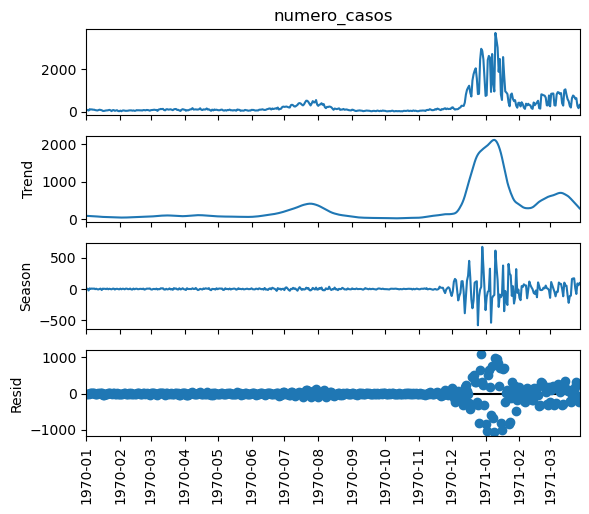

In [6]:
visualizar_STL(datos_Tenerife_arima_uni)

Realizamos la prueba de Dickey-Fuller para verificar si la serie temporal es estacionaria.

Esta prueba de 

In [7]:
visualizar_adf(datos_Tenerife_arima_uni)

ADF p-value:0.009618252771198928


Podemos observar que el p valor es inferior al valor de significancia 0.05 por lo que la serie temporal ya es estacionaria y por lo tanto el valor d del modelo ARIMA es 0

Realizamos un análisis de la Función de autocorrelación (ACF) para medir la correlación de la serie temporal y sus valores rezagados para determinar el valor de p

<Figure size 1600x1000 with 0 Axes>

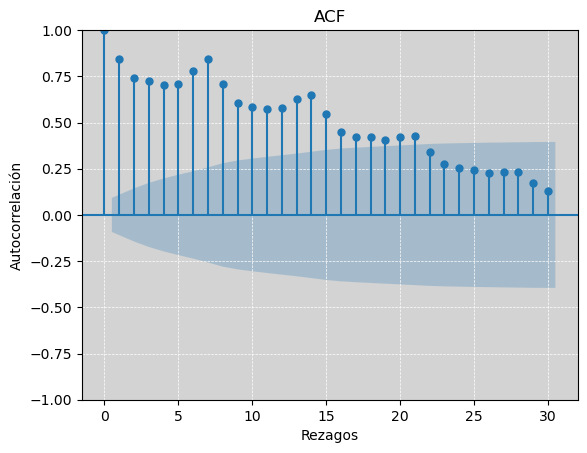

In [8]:
visualizar_acf(datos_Tenerife_arima_uni, 30)

Realizamos un análisis de la Función e Autocorrelación Parcial (PACF) para determinar el valor de q

<Figure size 1600x600 with 0 Axes>

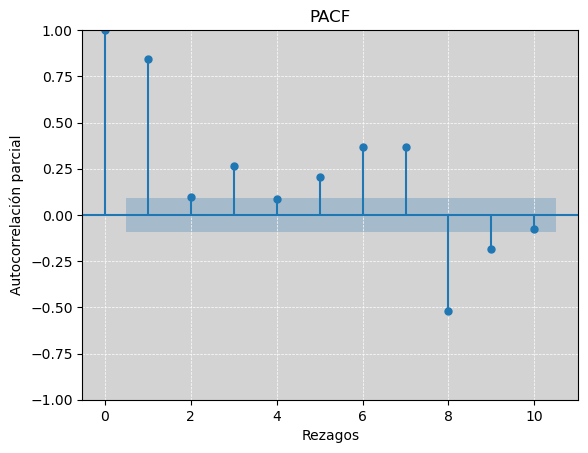

In [9]:
visualizar_pacf(datos_Tenerife_arima_uni, 10)

Definimos los valores de p, d y q optimos obtenidos por los análisis realizados

In [10]:
# Parámetros del modelo ARIMA
p = 2   # Parámetro Autorregresivo (AR)
d = 0   # Parámetro Integrado (I)
q = 6   # Parámetro Promedio Movil (MA)

# Modelo ARIMA univariable

In [11]:
# Conjuntos de entrenamiento y test
train = datos_Tenerife_arima_uni.iloc[:len(datos_Tenerife_arima_uni) - n_dias]
test =  datos_Tenerife_arima_uni.iloc[len(datos_Tenerife_arima_uni) - n_dias:]

In [12]:
arima_Tenerife = ARIMA(endog=train, order=(p, d, q), freq = 'D')
modelo_arima_Tenerife = arima_Tenerife.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
visualizar_bic_aic(modelo_arima_Tenerife)

BIC del modelo ARIMA: 6151.488052729505
AIC del modelo ARIMA: 6110.574953908728


<Figure size 1600x1000 with 0 Axes>

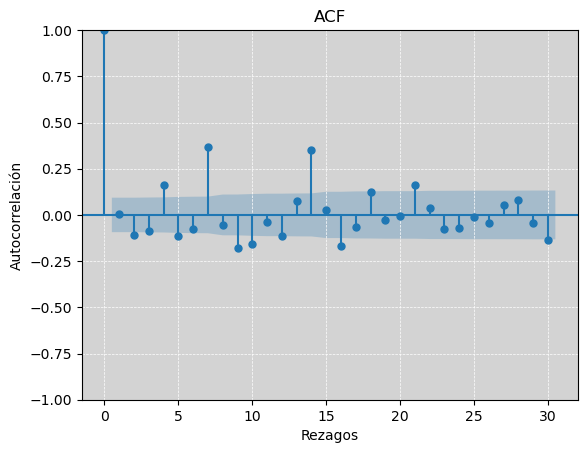

In [14]:
visualizar_acf(modelo_arima_Tenerife.resid, 30)

In [15]:
pred = modelo_arima_Tenerife.forecast(steps=10)
#pred = modelo_arima_Tenerife.predict(start=test.index[0], end=test.index[-1])

In [16]:
visualizar_resultados_texto(test, pred, '')

2022-03-19: número de casos reales 269, número de casos predichos 263.6797566127245
2022-03-20: número de casos reales 193, número de casos predichos 221.51756810717708
2022-03-21: número de casos reales 636, número de casos predichos 766.5170790661138
2022-03-22: número de casos reales 760, número de casos predichos 795.3491350139752
2022-03-23: número de casos reales 716, número de casos predichos 520.2719959917042
2022-03-24: número de casos reales 607, número de casos predichos 429.9322600850985
2022-03-25: número de casos reales 636, número de casos predichos 420.7747585836626
2022-03-26: número de casos reales 266, número de casos predichos 417.2562745501815
2022-03-27: número de casos reales 163, número de casos predichos 414.19968553543885
2022-03-28: número de casos reales 319, número de casos predichos 411.2483559165703


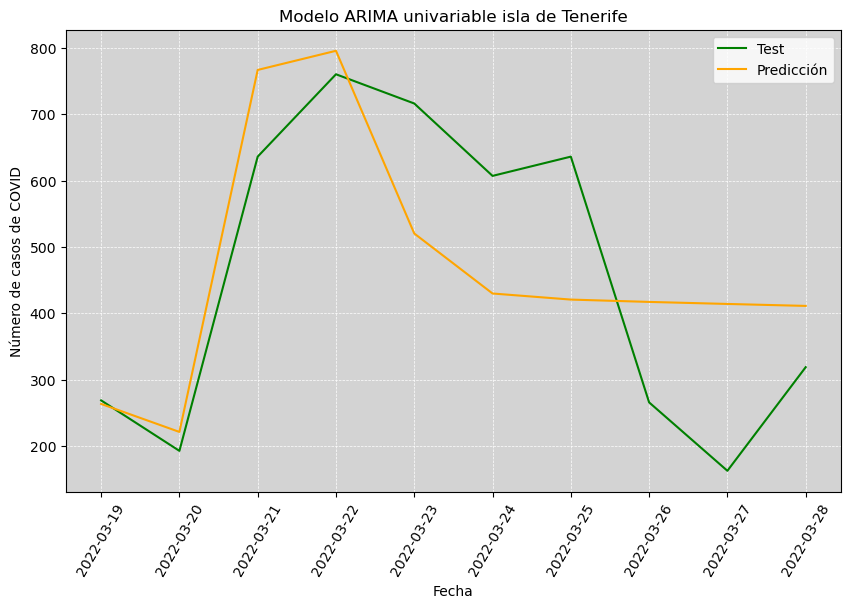

In [17]:
# Título para las visualizaciones
tit = 'Modelo ARIMA univariable isla de ' + isla
visualizar_dif_pred_test(test, pred, '', tit)

In [18]:
df_result = obtener_df_diferencias(test, pred, '')
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,269,263.679757,5.320243
2022-03-20,193,221.517568,-28.517568
2022-03-21,636,766.517079,-130.517079
2022-03-22,760,795.349135,-35.349135
2022-03-23,716,520.271996,195.728004
2022-03-24,607,429.932260,177.067740
2022-03-25,636,420.774759,215.225241
2022-03-26,266,417.256275,-151.256275
2022-03-27,163,414.199686,-251.199686


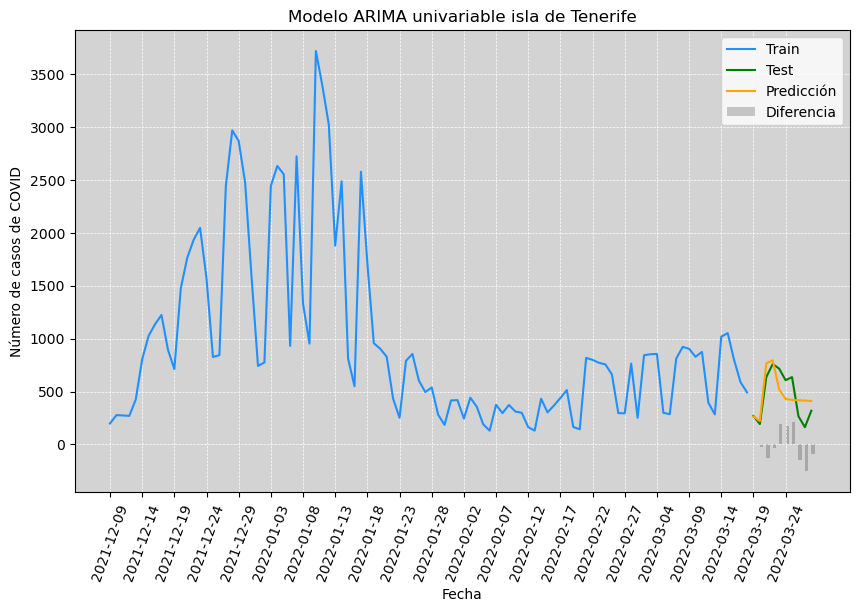

In [19]:
visualizar_historico(train, test, pred, '', n_dias_train_vis, tit, color_isla, df_result['dif'])

Para la evaluación del modelo se utilizará:
* MAE:
* MSE:
* RMSE:

In [20]:
mae, mse, rmse = obtener_errores(test, pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 22959.966834221057
Error absoluto medio (MAE) del modelo: 128.24293269162666
Raíz del error cuadrático medio (RMSE) del modelo: 151.52546595942565


# Modelo ARIMA multivariable con variables de pandemia

In [21]:
train = datos_Tenerife_arima_mult_covid.iloc[:len(datos_Tenerife_arima_mult_covid) - n_dias]
test =  datos_Tenerife_arima_mult_covid.iloc[len(datos_Tenerife_arima_mult_covid) - n_dias:]

In [22]:
#order=(p,d,q)
# Parámetros del modelo ARIMA

arima_Tenerife = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
modelo_arima_Tenerife = arima_Tenerife.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
visualizar_bic_aic(modelo_arima_Tenerife)

BIC del modelo ARIMA: 5814.674472286869
AIC del modelo ARIMA: 5757.396133937781


<Figure size 1600x1000 with 0 Axes>

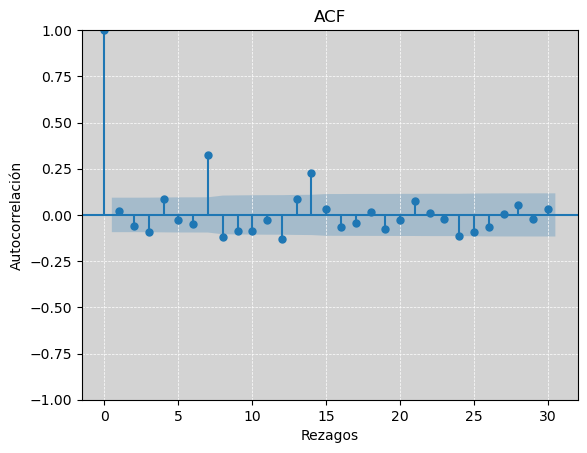

In [24]:
visualizar_acf(modelo_arima_Tenerife.resid, 30)

In [25]:
pred = modelo_arima_Tenerife.forecast(steps=10, exog=test[variables_covid])
#pred = modelo_arima_Tenerife.predict(start=test.index[0], end=test.index[-1], exog=test[variables_covid])

In [26]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 269, número de casos predichos 293.75284240925043
2022-03-20: número de casos reales 193, número de casos predichos 289.4490272138278
2022-03-21: número de casos reales 636, número de casos predichos 653.5966719485743
2022-03-22: número de casos reales 760, número de casos predichos 740.2267712437365
2022-03-23: número de casos reales 716, número de casos predichos 629.2809746242067
2022-03-24: número de casos reales 607, número de casos predichos 516.5169742367935
2022-03-25: número de casos reales 636, número de casos predichos 499.80815264402213
2022-03-26: número de casos reales 266, número de casos predichos 206.80452496889677
2022-03-27: número de casos reales 163, número de casos predichos 101.12126908268557
2022-03-28: número de casos reales 319, número de casos predichos 218.1693806923653


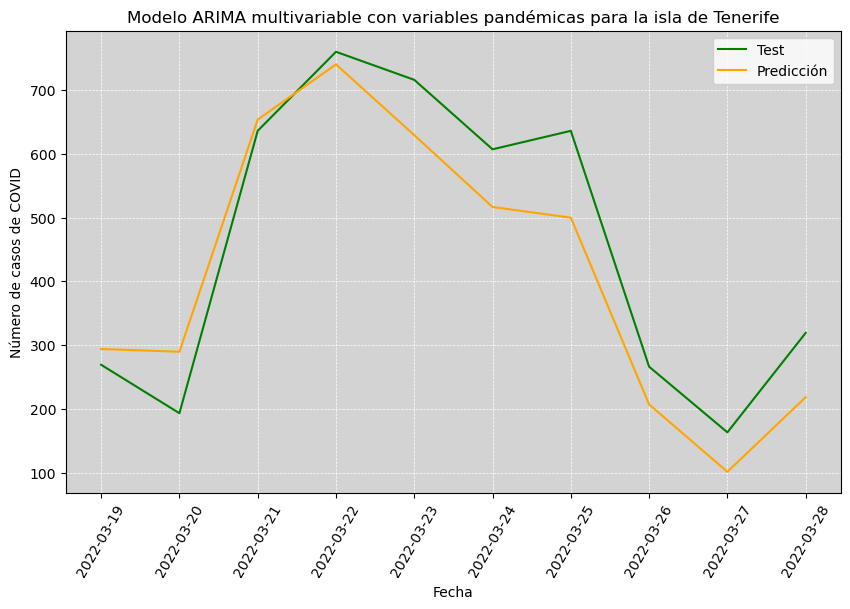

In [27]:
tit = 'Modelo ARIMA multivariable con variables pandémicas para la isla de ' + isla
visualizar_dif_pred_test(test, pred, objetivo, tit)

In [28]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,269,293.752842,-24.752842
2022-03-20,193,289.449027,-96.449027
2022-03-21,636,653.596672,-17.596672
2022-03-22,760,740.226771,19.773229
2022-03-23,716,629.280975,86.719025
2022-03-24,607,516.516974,90.483026
2022-03-25,636,499.808153,136.191847
2022-03-26,266,206.804525,59.195475
2022-03-27,163,101.121269,61.878731


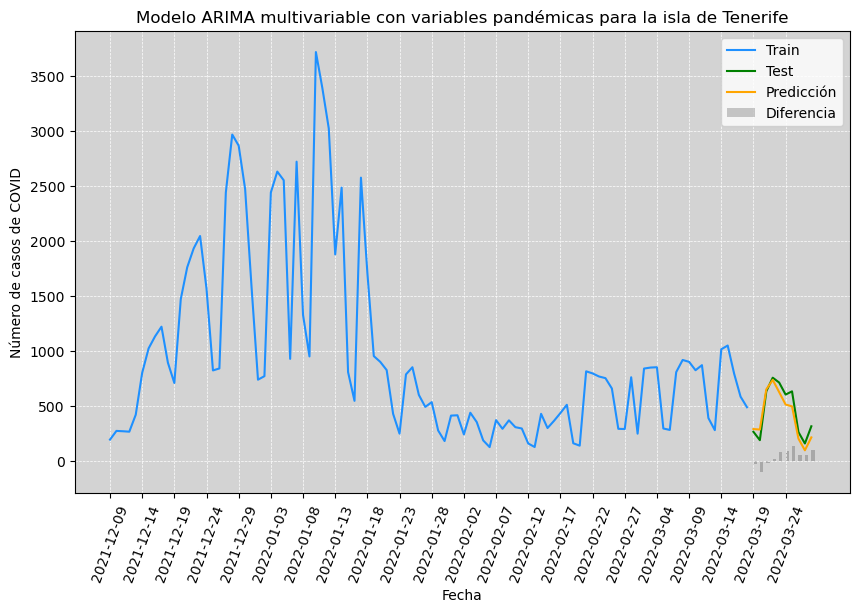

In [29]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

In [30]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 6237.122349062721
Error absoluto medio (MAE) del modelo: 69.38704940789461
Raíz del error cuadrático medio (RMSE) del modelo: 78.97545409215904


# Modelo ARIMA multivariable con variables atmosféricas

In [31]:
train = datos_Tenerife_arima_mult_atm.iloc[:len(datos_Tenerife_arima_mult_atm) - n_dias]
test =  datos_Tenerife_arima_mult_atm.iloc[len(datos_Tenerife_arima_mult_atm) - n_dias:]

In [32]:
arima_Tenerife = ARIMA(endog=train[objetivo],exog=train[variables_atm], order=(p, d, q), freq = 'D')
modelo_arima_Tenerife = arima_Tenerife.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
visualizar_bic_aic(modelo_arima_Tenerife)

BIC del modelo ARIMA: 6173.056991818861
AIC del modelo ARIMA: 6119.869963351851


<Figure size 1600x1000 with 0 Axes>

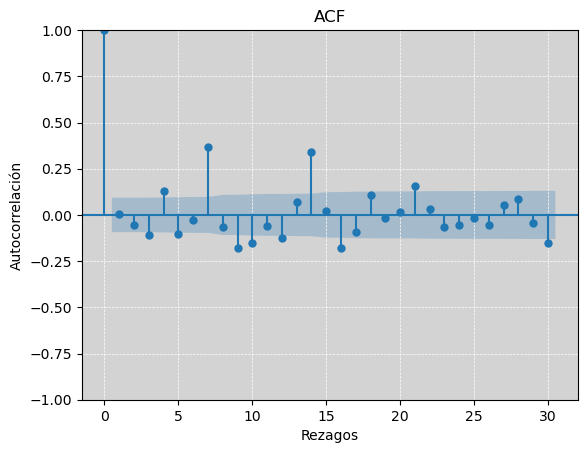

In [34]:
visualizar_acf(modelo_arima_Tenerife.resid, 30)

In [35]:
pred = modelo_arima_Tenerife.forecast(steps=10, exog=test[variables_atm])
#pred = modelo_arima_Tenerife.predict(start=test.index[0], end=test.index[-1], exog=test[variables_covid])

In [36]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 269, número de casos predichos 435.9098184446924
2022-03-20: número de casos reales 193, número de casos predichos 358.456021190023
2022-03-21: número de casos reales 636, número de casos predichos 749.803125068334
2022-03-22: número de casos reales 760, número de casos predichos 802.7612149758934
2022-03-23: número de casos reales 716, número de casos predichos 614.1193548077737
2022-03-24: número de casos reales 607, número de casos predichos 543.9239327053541
2022-03-25: número de casos reales 636, número de casos predichos 522.3997475581484
2022-03-26: número de casos reales 266, número de casos predichos 507.68021195057145
2022-03-27: número de casos reales 163, número de casos predichos 503.978782332135
2022-03-28: número de casos reales 319, número de casos predichos 511.57124006782647


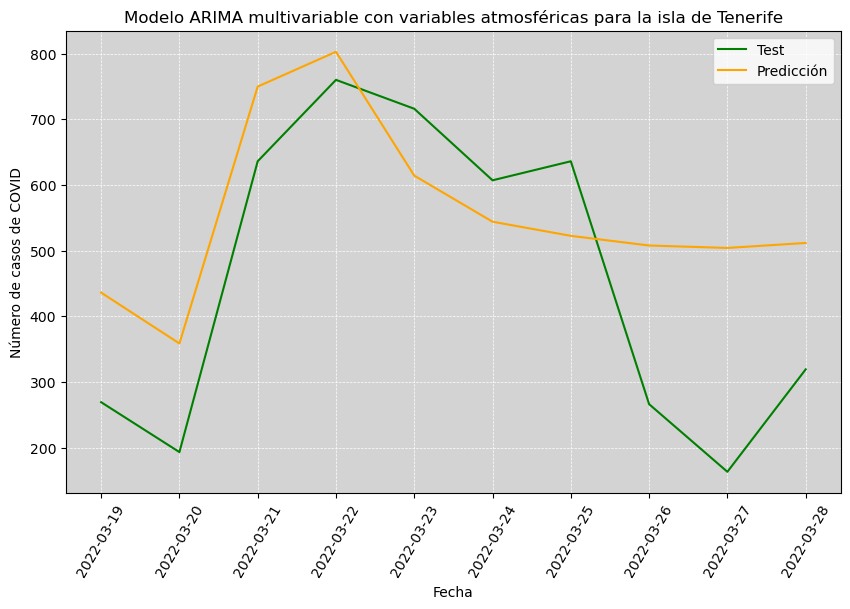

In [37]:
tit = 'Modelo ARIMA multivariable con variables atmosféricas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [38]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,269,435.909818,-166.909818
2022-03-20,193,358.456021,-165.456021
2022-03-21,636,749.803125,-113.803125
2022-03-22,760,802.761215,-42.761215
2022-03-23,716,614.119355,101.880645
2022-03-24,607,543.923933,63.076067
2022-03-25,636,522.399748,113.600252
2022-03-26,266,507.680212,-241.680212
2022-03-27,163,503.978782,-340.978782


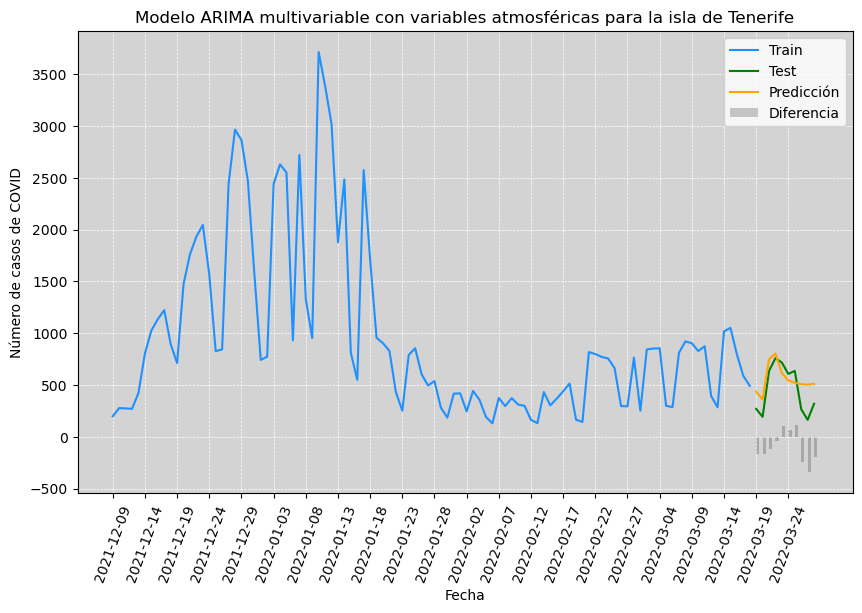

In [39]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

In [40]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 30903.706605824154
Error absoluto medio (MAE) del modelo: 154.27173789581997
Raíz del error cuadrático medio (RMSE) del modelo: 175.7945010682193


# Modelo ARIMA multivariable con todas las variables

In [41]:
train = datos_Tenerife_arima_total.iloc[:len(datos_Tenerife_arima_total) - n_dias]
test =  datos_Tenerife_arima_total.iloc[len(datos_Tenerife_arima_total) - n_dias:]

In [42]:
arima_Tenerife = ARIMA(endog=train[objetivo],exog=train[variables], order=(p, d, q), freq = 'D')
modelo_arima_Tenerife = arima_Tenerife.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
visualizar_bic_aic(modelo_arima_Tenerife)

BIC del modelo ARIMA: 5837.385809345855
AIC del modelo ARIMA: 5767.833541350534


<Figure size 1600x1000 with 0 Axes>

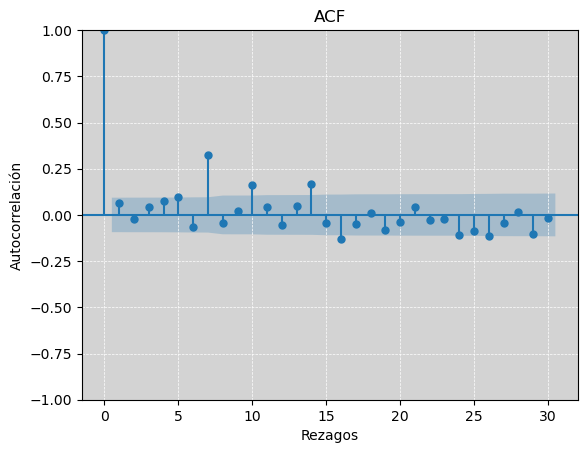

In [44]:
visualizar_acf(modelo_arima_Tenerife.resid, 30)

In [45]:
pred = modelo_arima_Tenerife.forecast(steps=10, exog=test[variables])
#pred = modelo_arima_Tenerife.predict(start=test.index[0], end=test.index[-1], exog=test[variables_covid])

In [46]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 269, número de casos predichos 297.8952693628752
2022-03-20: número de casos reales 193, número de casos predichos 323.37159735068815
2022-03-21: número de casos reales 636, número de casos predichos 620.3634741180614
2022-03-22: número de casos reales 760, número de casos predichos 667.7076724151425
2022-03-23: número de casos reales 716, número de casos predichos 520.4220089041876
2022-03-24: número de casos reales 607, número de casos predichos 405.13476550086006
2022-03-25: número de casos reales 636, número de casos predichos 366.39483683103697
2022-03-26: número de casos reales 266, número de casos predichos 121.39647496381033
2022-03-27: número de casos reales 163, número de casos predichos 9.496351243565847
2022-03-28: número de casos reales 319, número de casos predichos 150.7805232418342


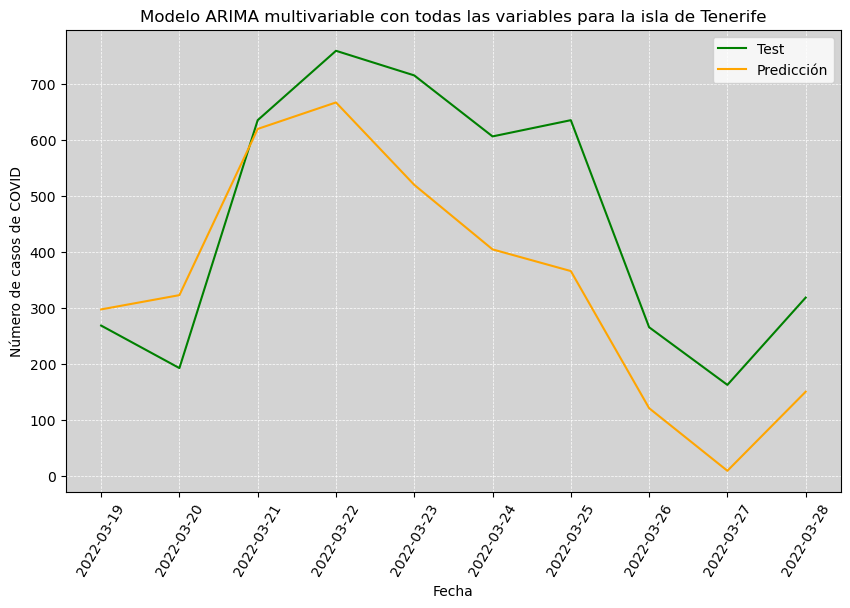

In [47]:
tit = 'Modelo ARIMA multivariable con todas las variables para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [48]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,269,297.895269,-28.895269
2022-03-20,193,323.371597,-130.371597
2022-03-21,636,620.363474,15.636526
2022-03-22,760,667.707672,92.292328
2022-03-23,716,520.422009,195.577991
2022-03-24,607,405.134766,201.865234
2022-03-25,636,366.394837,269.605163
2022-03-26,266,121.396475,144.603525
2022-03-27,163,9.496351,153.503649


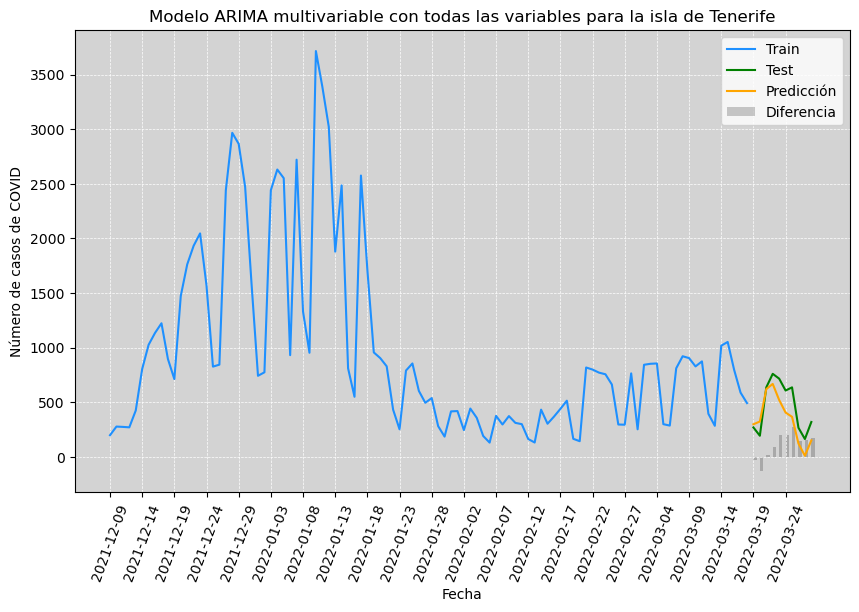

In [49]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

In [50]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 25105.267416306164
Error absoluto medio (MAE) del modelo: 140.05707594950644
Raíz del error cuadrático medio (RMSE) del modelo: 158.4464181239392
